# Using Auxiliary Variables in MCMC proposals

## Slice sampling

Slice sampling is a simple MCMC algorithm that introudces the idea of auxiliary variables. The motivation for slice sampling is that if we can sample uniformly from the region under the graph of the target distribution, we will have random samples from the target distribution. In the univariate case, the algorithm is as follows

- start with some $x$ where $p(x) \ne 0$
- repeat
    - sample $y$ (auxiliary variable) uniformly from 0 to $f(x)$
    - draw a horizontal line at $y$ within $p(x)$ (this may consist of multiple intervals)
    - sample $x$ from the horizontal segments

The auxiliary $y$ variable allows us to sample $(x, y)$ points that are in the region under the graph of the target distribution. Only the $x$ variable is used for the Monte Carlo samples - the $y$ variables are simply discarded. It is a Markov Chain Monte Carlo method since the next $(x, y)$ position depends only on the current position. Like Gibbs sampling, there is no tuning process and all proposals are accepted. For slice sampling, you either need the inverse distribution function or some way to estimate it. Later we will see that Hamiltonian Monte Carlo also uses auxiliary variables to generate a new proposal in an analogous way.

A toy example illustrates the process - Suppose we want to draw random samples from the posterior distribution $\mathcal{N}(0, 1)$ using slice sampling

Start with some value $x$
- sample $y$ from $\mathcal{U}(0, f(x))$ - this is the horizontal "slice" that gives the method its name
- sample the next $x$ from $f^{-1}(y)$ - this is typically done numerically
- repeat

Will sketch picture in class to show what is going on.

## A simple slice sampler example

In [3]:
import scipy.stats as stats

In [4]:
dist = stats.norm(5, 3)
w = 0.5
x = dist.rvs()

niters = 1000
xs = []
while len(xs) < niters:
    y = np.random.uniform(0, dist.pdf(x))
    lb = x
    rb = x
    while y < dist.pdf(lb):
        lb -= w
    while y < dist.pdf(rb):
        rb += w
    x = np.random.uniform(lb, rb)
    if y > dist.pdf(x):
        if np.abs(x-lb) < np.abs(x-rb):
            lb = x
        else:
            lb = y
    else:
        xs.append(x)

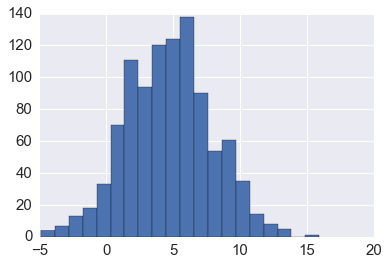

In [5]:
plt.hist(xs, 20)
pass

Notes on the slice sampler:

- the slice may consist of disjoint pieces for multimodal distributions
- the slice can be a rectangular hyperslab for multivariable posterior distributions
- sampling from the slice (i.e. finding the boundaries at level $y$) is non-trivial and may involve iterative rejection steps - see figure below (from Wikimedia) for a typical approach - the blue bars represent disjoint pieces of the true slice through a bimodal distribution and the black lines are the proposal distribution approximating the true slice

![Slice sampling algorithm from Wikipedia](http://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Summary_of_slice_sampling.png/750px-Summary_of_slice_sampling.png)

## Hamiltonian Monte Carlo (HMC)

HMC uses an auxiliary variable corresponding to the momentum of particles in a potential energy well to generate proposal distributions that can make use of gradient information in the posterior distribution. For reversibility to be maintained, the total energy of the particle has to be conserved - hence we are interested in Hamiltonian systems. The main attraction of HMC is that it works much better than other methods when variables of interest are highly correlated. Because we have to solve problems involving momentum, we need to understand how to numerically solve differential equations in a way that is both accurate (i.e. second order) and preserves total energy (necessary for a Hamiltonian system).

## A simple Hamiltonian system

We will consider solving a classical Hamiltonian system - that of a undamped spring governed by the second order differential equation

$$
u'' + u = 0
$$

We convert this to two first order ODEs by using a dummy variable $u' = v$ to get

$$
\begin{align}
u' &= v \\
v' &= -u
\end{align}
$$

Writing in matrix form,

$$
A = \pmatrix{ u' \\ v' } = \pmatrix{0 & 1 \\ -1 & 0}
$$

and in general, for the state vector $u$,

$$
u' = Au
$$

We note that $A$ is anti- or skew-symmetric ($A^T = -A$), and hence has purely imaginary eigenvalues. Solving $|A - \lambda I = 0$, we see that the eigenvalues and eigenvectors are $i, \pmatrix{1\\i}$ and $-i, \pmatrix{1\\-i}$. Since the eigenvalues are pure imaginary, we see that the solution for the initial conditions $(u,v) = (1, 0)$ is $u(t) = e^{it}$ and the orbit just goes around a circle with a period of $2\pi$, neither growing nor decaying. Another weay of seeing this is that the Hamiltonian $H(u, v)$ or sum of potential ($U(u)) = \frac{1}{2}u^2$) and kinetic energy ($K(v) = \frac{1}{2}v^2$) is constant, i.e. in vector form, $(u^Tu) = \text{constant}$.

## Finite difference methods

We want to find a finite difference approximation to $u' = Au$ that is **accurate** and **preserves total energy**. If total energy is not preserved, the orbit will either spiral in towards zero or outwards away from the unit circle. If the accuracy is poor, the orbit will not be close to its starting value after $t = 2\pi$. This gives us an easy way to visualize how good our numerical scheme is. We can also compare the numerical scheme to the Taylor series to evaluate its accuracy.

### Forward Euler

The simplest finite difference scheme for integrating ODEs is the forward Euler

$$
\frac{u_{n+1} - u_n}{\Delta t} = A u_n
$$

Rearranging terms, we get

$$
u_{n+1} = u_n + \Delta t A u_n = \left( I + \Delta t A \right) u_n
$$

Since the eigenvalues of $A$ are $\pm i$, we see that the eigenvalues of the forward Euler matrix are $1 \pm i$. Since the absolute value of the eigenvalues is greater than 1, we expect **growing** solutions - i.e. the solution will spiral away from the unit circle.

In [1]:
import scipy.linalg as la

In [2]:
def f_euler(A, u, N):
    orbit = np.zeros((N,2))

    for i in range(N):
        dt = 2*np.pi/N
        u = u + dt * A @ u
        orbit[i] = u
    return orbit

In [3]:
A = np.array([[0,1],[-1,0]])
u = np.array([1.0,0.0])
N = 64
orbit = f_euler(A, u, N)

#### Accuracy

In [4]:
la.norm(np.array([1.0,0.0]) - orbit[-1])

0.3600318484671192

#### Conservation of energy

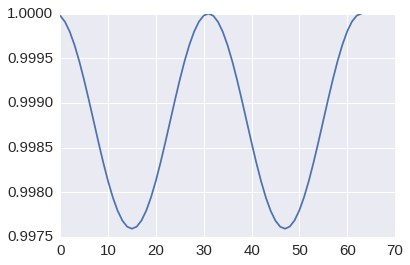

In [19]:
plt.plot([p@p for p in orbit])
pass

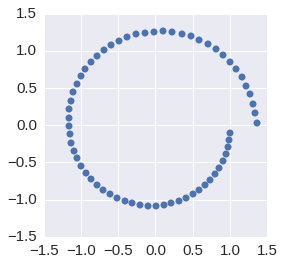

In [6]:
ax = plt.subplot(111)
plt.plot(orbit[:, 0], orbit[:,1], 'o')
ax.axis('square')
plt.axis([-1.5, 1.5, -1.5, 1.5])
pass

#### Accuracy and conservation of energy

We can see that forward Euler is not very accurate and also does not preserve energy since the orbit spirals away from the unit circle.

### The trapezoidal method

The trapezoidal method uses the following scheme

$$
\frac{u_{n+1} - u_n}{\Delta t} = \frac{1}{2}  ( A u_{n+1} + A u_{n})
$$

This is an implicit scheme (because $u_{n+1}$ appears on the RHS) whose solution is

$$
u_{n+1} = \left(I - \frac{\Delta t}{2} A \right)^{-1} \left(I + \frac{\Delta t}{2} A \right) u_{n} = B u_n
$$

By inspection, we see that the eigenvalues are the complex conjugates of

$$
\frac{1 + \frac{\Delta t}{2} i}{1 - \frac{\Delta t}{2} i}
$$

whose absolute value is 1 - hence, energy is conserved. If we expand the matrix $B$ using the geometric series and compare with the Taylor expansion, we see that the trapezoidal method has local truncation error $O(h^3)$ and hence accuracy $O(h^2)$, where $h$ is the time step.

In [7]:
def trapezoidal(A, u, N):
    orbit = np.zeros((N,2))

    for i in range(N):
        dt = 2*np.pi/N
        u = la.inv(np.eye(2) - dt/2 * A) @ (np.eye(2) + dt/2 * A) @ u
        orbit[i] = u
    return orbit

In [8]:
A = np.array([[0,1],[-1,0]])
u = np.array([1.0,0.0])
N = 64
orbit = trapezoidal(A, u, N)

#### Accuracy

In [9]:
la.norm(np.array([1.0,0.0]) - orbit[-1])

0.005039305635733781

#### Conservation of energy

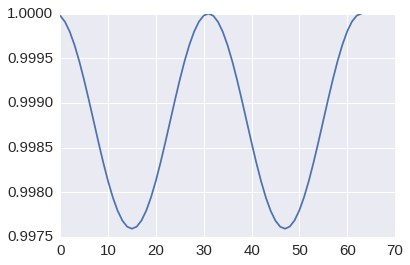

In [20]:
plt.plot([p@p for p in orbit])
pass

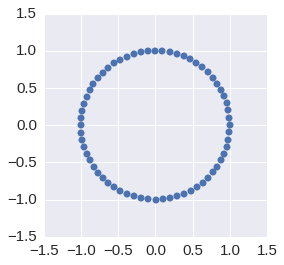

In [11]:
ax = plt.subplot(111)
plt.plot(orbit[:, 0], orbit[:,1], 'o')
ax.axis('square')
plt.axis([-1.5, 1.5, -1.5, 1.5])
pass

### The leapfrog method

The leapfrog method uses a second order difference to update $u_n$. The algorithm simplifies to the following explicit scheme:

- First take one half-step for u
- Then take a full step for v
- Then take one final half step for u

It performs as well as the trapezoidal method, with the advantage of being an explicit scheme and cheaper to calculate, so the leapfrog method is used in HMC.

In [12]:
def leapfrog(A, u, N):
    orbit = np.zeros((N,2))

    for i in range(N):
        dt = 2*np.pi/N
        u[1] = u[1] + dt/2 * A[1] @ u
        u[0] = u[0] + dt * A[0] @ u
        u[1] = u[1] + dt/2 * A[1] @ u
        orbit[i] = u
    return orbit

In [13]:
A = np.array([[0,1],[-1,0]])
u = np.array([1.0,0.0])
N = 64
orbit = leapfrog(A, u, N)

#### Accuracy

In [14]:
la.norm(np.array([1.0,0.0]) - orbit[-1])

0.0025229913808033464

#### Conservation of energy

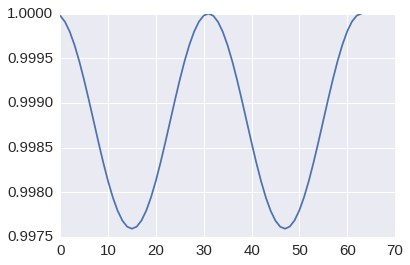

In [21]:
plt.plot([p@p for p in orbit])
pass

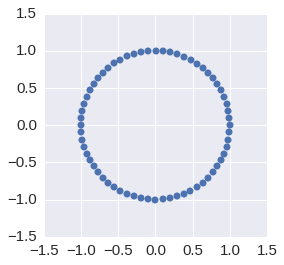

In [16]:
ax = plt.subplot(111)
plt.plot(orbit[:, 0], orbit[:,1], 'o')
ax.axis('square')
plt.axis([-1.5, 1.5, -1.5, 1.5])
pass

## From Hamiltonians to probability distributions

From statistical mechanics, the total energy or $H(u,v) = U(u) + K(v)$ is related to the canonical probability distribution

$$
\begin{align}
p(\theta) &= e^{-H(\theta)}  \\
&= e^{-U9u) - K(v)
\end{align}
$$